# Hydrometer

In [3]:
%matplotlib notebook
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from sklearn import model_selection
from sklearn.model_selection import train_test_split
import scipy as scp

## Data Pre-processing

### Load Data 

In [280]:
df = pd.read_csv('/home/humannoise/Desktop/Data Sample/SQL - Stattus4V2.csv',sep=';')
df.dropna(axis=0,thresh=1)
df.head(10)

,matricula_c_digito,numero_hidrometro,volume_lido,consumo_faturado,ocorrencia,modelo_hidrometro,tipo_hd,diametro,qn,classe,ref_medicao
0,83071-2,Y14S544375,4.0,10.0,0,176.0,Unijato,"3/4""","1,5000000000000000",B,2018-12-01
1,83071-2,Y14S544375,5.0,10.0,0,176.0,Unijato,"3/4""","1,5000000000000000",B,2018-11-01
2,83071-2,Y14S544375,4.0,10.0,0,176.0,Unijato,"3/4""","1,5000000000000000",B,2018-10-01
3,83071-2,Y14S544375,4.0,10.0,0,176.0,Unijato,"3/4""","1,5000000000000000",B,2018-09-01
4,83071-2,Y14S544375,5.0,10.0,0,176.0,Unijato,"3/4""","1,5000000000000000",B,2018-08-01
5,83071-2,Y14S544375,5.0,10.0,0,176.0,Unijato,"3/4""","1,5000000000000000",B,2018-07-01
6,83071-2,Y14S544375,4.0,10.0,0,176.0,Unijato,"3/4""","1,5000000000000000",B,2018-06-01
7,83071-2,Y14S544375,2.0,10.0,0,176.0,Unijato,"3/4""","1,5000000000000000",B,2018-05-01
8,83071-2,Y14S544375,2.0,10.0,0,176.0,Unijato,"3/4""","1,5000000000000000",B,2018-04-01
9,83071-2,Y14S544375,1.0,10.0,0,176.0,Unijato,"3/4""","1,5000000000000000",B,2018-03-01


### Time-Series of Monthly Consumption by hidrometer

In [6]:
col = df.get('numero_hidrometro')
col.head(10)

0    Y14S544375
1    Y14S544375
2    Y14S544375
3    Y14S544375
4    Y14S544375
5    Y14S544375
6    Y14S544375
7    Y14S544375
8    Y14S544375
9    Y14S544375
Name: numero_hidrometro, dtype: object

In [281]:
df0 = df.copy().set_index('numero_hidrometro')
df0.head()

,matricula_c_digito,volume_lido,consumo_faturado,ocorrencia,modelo_hidrometro,tipo_hd,diametro,qn,classe,ref_medicao
numero_hidrometro,,,,,,,,,,
Y14S544375,83071-2,4.0,10.0,0,176.0,Unijato,"3/4""","1,5000000000000000",B,2018-12-01
Y14S544375,83071-2,5.0,10.0,0,176.0,Unijato,"3/4""","1,5000000000000000",B,2018-11-01
Y14S544375,83071-2,4.0,10.0,0,176.0,Unijato,"3/4""","1,5000000000000000",B,2018-10-01
Y14S544375,83071-2,4.0,10.0,0,176.0,Unijato,"3/4""","1,5000000000000000",B,2018-09-01
Y14S544375,83071-2,5.0,10.0,0,176.0,Unijato,"3/4""","1,5000000000000000",B,2018-08-01


In [282]:
hydrometer_ts = {k:np.array(df0.loc[k,'volume_lido']) for k in np.array(df0.index.unique())}

In [283]:
def demean_dict(d,std=False):
  for k,v in d.items():
    if std == True:
      d[k] = (v - v.mean())/(v.std()+1e-6)
    else:
      d[k] = v - v.mean()    

In [227]:
demean_dict(hydrometer_ts)
#print(hydrometer_ts)

### Plot Time-Series Grid

<IPython.core.display.Javascript object>


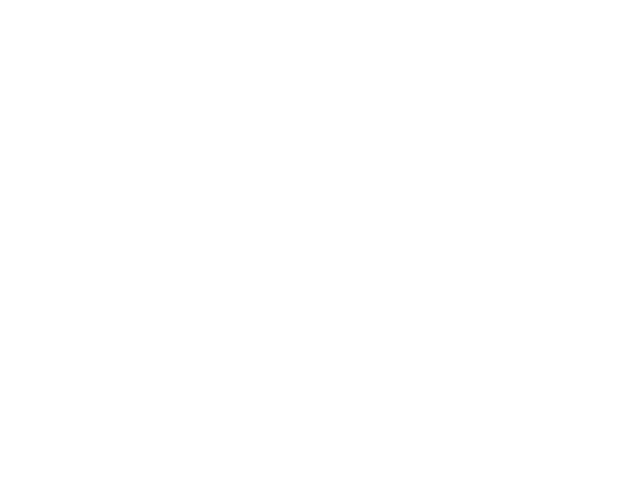

<IPython.core.display.Javascript object>


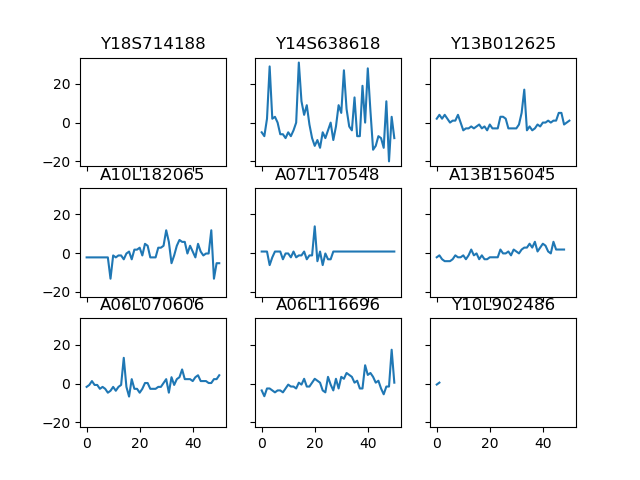

In [39]:
plt.figure()
# create a 3x3 grid of subplots
fig, ((ax1,ax2,ax3), (ax4,ax5,ax6), (ax7,ax8,ax9)) = plt.subplots(3, 3, sharex=True, sharey=True)
    
axs = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

for i in range(9):
  axs[i].plot(hydrometer_ts[hydrometer_ts.keys()[i]], '-')
  axs[i].set_title('{}'.format(hydrometer_ts.keys()[i]))

### Retirar Sazonalidades

#### Sazonalidades por hidrometros, Autocorrelacao

<IPython.core.display.Javascript object>


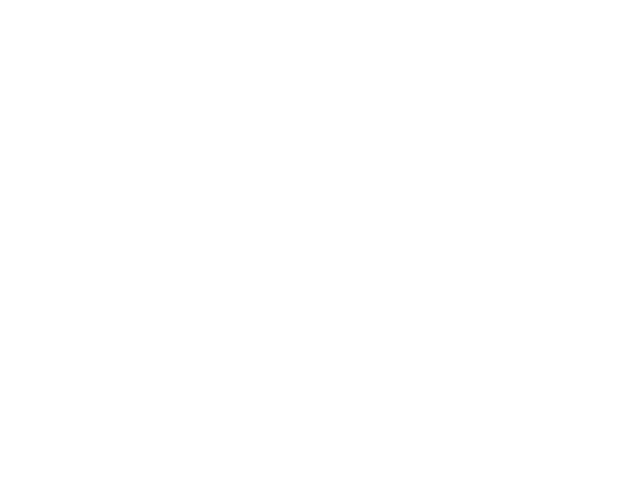

<IPython.core.display.Javascript object>


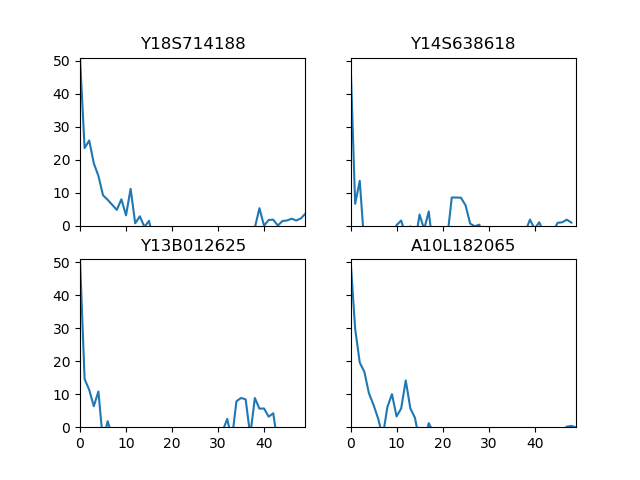

[ 5.10000000e+01  2.35256499e+01  2.58355693e+01  1.89086960e+01
  1.51050674e+01  9.21336716e+00  7.85054915e+00  6.30693035e+00
  4.77926456e+00  7.97723481e+00  3.10475462e+00  1.11595301e+01
  6.98178785e-01  2.82020715e+00 -3.75434450e-01  1.43462394e+00
 -4.87539969e+00 -5.57173641e+00 -1.28017169e+01 -1.07027318e+01
 -1.34534617e+01 -1.54721257e+01 -7.34999305e+00 -1.16871611e+01
 -5.06106631e+00 -6.58873210e+00 -6.05314194e+00 -9.93121785e+00
 -9.90435145e+00 -1.34279160e+01 -1.10914083e+01 -1.26580703e+01
 -1.28775893e+01 -5.26418045e+00 -7.07013763e+00 -3.24645489e+00
 -3.22845127e+00 -8.75990546e-01 -6.36417350e-01  5.28242736e+00
 -2.61017656e-02  1.70064646e+00  1.80018768e+00  2.61365216e-02
  1.39128319e+00  1.56527179e+00  2.10086195e+00  1.54278465e+00
  2.16877520e+00  3.64913805e+00]
[50.          6.61730846 13.60182612 -5.89241763 -4.59468043 -2.95950774
 -1.6419214  -4.40333466 -5.15998412 -4.1302104   0.14489877  1.53195713
 -2.85708615 -0.22945613 -5.38269154  3.

In [148]:
plt.figure()
# create a 3x3 grid of subplots
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, sharex=True, sharey=True)
func = lambda ts: scp.correlate(ts,ts, mode="full")/scp.var(ts)
axs = [ax1,ax2,ax3,ax4]

    
j=20
for i in range(4):
  j = j+i
  ts = hydrometer_ts[hydrometer_ts.keys()[j]]
  while np.size(ts) < 20:          
    j += 1
    ts = hydrometer_ts[hydrometer_ts.keys()[j]]
  
  n = int(np.size(scp.correlate(ts,ts, mode="full"))/2.0)
  x = np.linspace(0,n-1, n).astype(np.int32)  
  print(func(ts)[n:2*n])
  axs[i].axis([0.0,x[-1],0.0, np.max(func(ts)[n:2*n])])
  axs[i].plot(x, func(ts)[n:2*n],'-')
  axs[i].set_title('{}'.format(hydrometer_ts.keys()[i]))

<IPython.core.display.Javascript object>


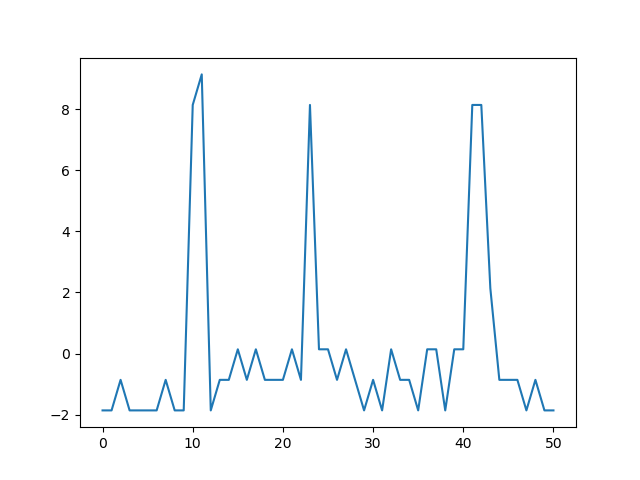

('Season', 25)


In [228]:
#Tirar Sazonalidades por diferencas

ts = hydrometer_ts[hydrometer_ts.keys()[50]].copy()
n = int(np.size(scp.correlate(ts,ts, mode="full"))/2.0)
acf = np.array([ np.mean(func(ts)[i:i+10]) for i in range(n,2*n-10) ] )

plt.figure()
plt.plot(ts)

for i in range(1,len(acf)):
    if np.abs( acf[i]-np.max(acf[1:]) ) < 0.001:
        season = i
        print('Season',season)    
        
for i in range(len(ts)):
    ts[i] = ts[i]-ts[np.mod(i+season,np.size(ts))]

<IPython.core.display.Javascript object>


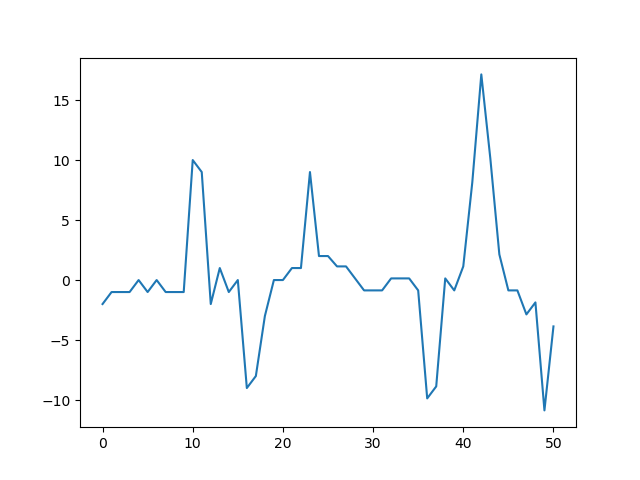

In [229]:
plt.figure()
plt.plot(ts)

#### Retirar efeito Sazonal simultaneo dos hidrometros

<IPython.core.display.Javascript object>


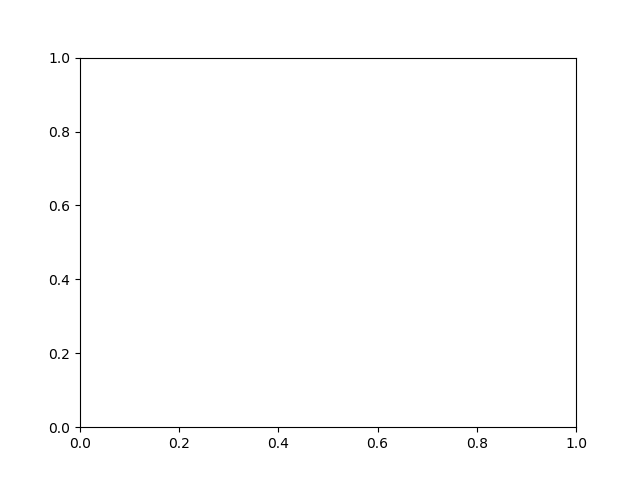

ValueError: max must be larger than min in range parameter.

In [293]:
ts_overall = df.loc[:,'volume_lido'].copy()
#ts_overall[ts_overall > 100] = 0
#plt.figure()
#plt.hist(ts_overall,bins=400)

In [241]:
'''ts = ts_overall
n = int(np.size(scp.correlate(ts,ts, mode="full"))/2.0)
acf = np.array([ np.mean(func(ts)[i:i+15]) for i in range(n,2*n-15) ] )

plt.figure()
plt.plot(ts)

for i in range(1,len(acf)):
    if np.abs( acf[i]-np.max(acf[1:]) ) < 0.001:
        season = i
        print('Season',season)    
        
for i in range(len(ts)):
    ts[i] = ts[i]-ts[np.mod(i+season,np.size(ts))]'''

KeyboardInterrupt: 

In [288]:
hydrometer_ts = {k:np.array(df0.loc[k,'volume_lido']) for k in np.array(df0.index.unique())}
demean_dict(hydrometer_ts,std=True)

count_out = 0;
for k in hydrometer_ts.keys():
  nsize = np.size(hydrometer_ts[k])
  
  if nsize > 1:    
    if nsize < 40 or np.isnan(hydrometer_ts[k]).any():
      hydrometer_ts.pop(k)
      count_out += 1
  else:
    hydrometer_ts.pop(k)  
  
print(count_out)
print(len(hydrometer_ts.keys()))

306
1929


In [289]:
m = np.array([hydrometer_ts[k][0:40] for k in hydrometer_ts.keys()])

In [290]:
mcov = np.cov(m)
eigv = np.linalg.eigvals(mcov)
print(mcov)
print("Autovalores da covariancia 'PCA' ", np.int32(eigv[0:80]))
print("Numero de autovalores nao nulos ", len(np.nonzero(np.int32(eigv[0:80]))[0]))

[[ 0.89636042  0.03284893  0.02468102 ...  0.1047588   0.06390081
   0.21443468]
 [ 0.03284893  1.18429671 -0.38940999 ... -0.35822238  0.21521728
   0.11589008]
 [ 0.02468102 -0.38940999  0.82662249 ...  0.48229319  0.04388955
  -0.3004819 ]
 ...
 [ 0.1047588  -0.35822238  0.48229319 ...  1.15706591  0.18798646
  -0.28662644]
 [ 0.06390081  0.21521728  0.04388955 ...  0.18798646  0.48096258
  -0.05194238]
 [ 0.21443468  0.11589008 -0.3004819  ... -0.28662644 -0.05194238
   0.96735942]]
("Autovalores da covariancia 'PCA' ", array([276, 153, 102,  93,  82,  69,  60,  53,  46,  43,  41,  39,  36,
        35,  33,  33,  32,  30,  29,  29,  28,  28,  16,  26,  26,  25,
        18,  19,  24,  24,  23,  20,  23,  23,  22,  20,  21,  21,  21,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0], dtype=int32))
('Nume

/home/humannoise/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
/home/humannoise/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: ComplexWarning: Casting complex values to real discards the imaginary part


In [ ]:
plt.figure()
plt.plot(ts)

#### Há alguma baixa dimensionalidade delineando o consumo nos hidrometros ? PCA para analisar dimensoes da variância

In [ ]:
scp.

#### X features

In [129]:
X = df.iloc[:,[2:]]
X.head(10)

,fruit_subtype,mass,width,height,color_score
0,granny_smith,192.0,8.4,7.3,0.55
1,granny_smith,180.0,8.0,6.8,0.59
2,granny_smith,176.0,7.4,7.2,0.60
3,mandarin,86.0,6.2,4.7,0.80
4,mandarin,84.0,6.0,4.6,0.79
5,mandarin,80.0,5.8,NaN,0.77
6,mandarin,80.0,5.9,4.3,0.81
7,mandarin,76.0,5.8,4.0,NaN
8,braeburn,178.0,7.1,7.8,0.92
9,braeburn,172.0,7.4,7.0,0.89


#### y labels for supervised learning

In [12]:
y = df.iloc[:,0]
y.head()

0    1
1    1
2    1
3    2
4    2
Name: fruit_label, dtype: int64

#### y labels names

In [13]:
y_names = df.iloc[:,1]
y_names.unique()

array(['apple', 'mandarin', 'orange', 'lemon'], dtype=object)

- Beyond `Data Cleaning` and `Exploratory Analysis`.
- Preparing Data for modeling, finding numerical representation.
- Treating `Missing Data`. Removing ...

### Remove columns in DataFrame based on a threshold of at least  3 na

In [ ]:
df.dropna(axis=1,thresh=3)

### Subset column feature to exclude null values

In [ ]:
# Check how many values are missing in the category_desc column
print(df['category_desc'].isnull().sum())

# Subset the volunteer dataset
dfs = volunteer[volunteer['category_desc'].notnull()]

# Print out the shape of the subset
print(dfs.shape)

### Treating Missing Data with Scikit-Learn Imputer

In [29]:
from sklearn.preprocessing import Imputer

In [52]:
imputer = Imputer(missing_values= 'NaN',strategy= 'mean', axis=0)

In [117]:
X.iloc[:,1:] = imputer.fit_transform(X.iloc[:,1:])
X.head(10)

,fruit_subtype,mass,width,height,color_score
0,granny_smith,192.0,8.4,7.300000,0.550000
1,granny_smith,180.0,8.0,6.800000,0.590000
2,granny_smith,176.0,7.4,7.200000,0.600000
3,mandarin,86.0,6.2,4.700000,0.800000
4,mandarin,84.0,6.0,4.600000,0.790000
5,mandarin,80.0,5.8,7.732143,0.770000
6,mandarin,80.0,5.9,4.300000,0.810000
7,mandarin,76.0,5.8,4.000000,0.762727
8,braeburn,178.0,7.1,7.800000,0.920000
9,braeburn,172.0,7.4,7.000000,0.890000


### Categorical Data Preprocessing

#### Naive Label Encoding

In [80]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [ ]:
labelenconderX = LabelEncoder()
X.iloc[:,0] = labelenconderX.fit_transform(X.iloc[:,0])
X.head(10)

#### Dummy Encoding/ One Hot Encoding. Since label encoding gives numbers that can be ordered, and you dont wanna your algorithm to consider any label prior than the others, than you encode it as an array with length equals the number of label and with all the terms equals to zero, except the one that represents the label.

In [128]:
X = pd.merge(pd.get_dummies(X.iloc[:,0]),X.iloc[:,1:],how= 'outer',right_index=True,left_index=True)
X.head(10)

,0,1,cripps_pink,golden_delicious,granny_smith,mandarin,selected_seconds,spanish_belsan,spanish_jumbo,turkey_navel,unknown,mass,width,height,color_score
0,1,0,0,0,1,0,0,0,0,0,0,192.0,8.4,7.300000,0.550000
1,1,0,0,0,1,0,0,0,0,0,0,180.0,8.0,6.800000,0.590000
2,1,0,0,0,1,0,0,0,0,0,0,176.0,7.4,7.200000,0.600000
3,1,0,0,0,0,1,0,0,0,0,0,86.0,6.2,4.700000,0.800000
4,1,0,0,0,0,1,0,0,0,0,0,84.0,6.0,4.600000,0.790000
5,1,0,0,0,0,1,0,0,0,0,0,80.0,5.8,7.732143,0.770000
6,1,0,0,0,0,1,0,0,0,0,0,80.0,5.9,4.300000,0.810000
7,1,0,0,0,0,1,0,0,0,0,0,76.0,5.8,4.000000,0.762727
8,0,1,0,0,0,0,0,0,0,0,0,178.0,7.1,7.800000,0.920000
9,0,1,0,0,0,0,0,0,0,0,0,172.0,7.4,7.000000,0.890000


### Working with Data Types

#### Usual data types: object for string or mixed objects, int64, float64, datetype64 (timedelta) for datetime

In [119]:
print(X.dtypes)

braeburn              uint8
cripps_pink           uint8
golden_delicious      uint8
granny_smith          uint8
mandarin              uint8
selected_seconds      uint8
spanish_belsan        uint8
spanish_jumbo         uint8
turkey_navel          uint8
unknown               uint8
mass                float64
width               float64
height              float64
color_score         float64
dtype: object


#### Convert column to determined type

In [ ]:
# Convert the hits column to type int
X["hits"] = X['hits'].astype(int)

# Look at the dtypes of the dataset
print(X.dtypes)

### Splitting Dataset, Class imbalance
#### For uneven dataset, you will need to change the ratio spleeting of the data between training and test data. This is done by passing the label of the dataset to stratify variable.

In [124]:
# Use stratified sampling to split up the dataset according to the y dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.25)

# Print out the counts on the training y labels
print(y_test.value_counts())

3    5
1    5
4    4
2    1
Name: fruit_label, dtype: int64


### Features Scaling

In [125]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [127]:
print(X_train)

[[-0.27050089 -0.31622777 -0.35805744 -0.21821789 -0.31622777  3.16227766
  -0.39735971 -0.27050089 -0.43495884 -0.39735971 -0.49438706 -0.61672281
  -0.52079393 -0.53225569]
 [-0.27050089  3.16227766 -0.35805744 -0.21821789 -0.31622777 -0.31622777
  -0.39735971 -0.27050089 -0.43495884 -0.39735971 -0.22627392  0.21743928
  -0.05646157  1.09391005]
 [-0.27050089 -0.31622777 -0.35805744 -0.21821789 -0.31622777  3.16227766
  -0.39735971 -0.27050089 -0.43495884 -0.39735971  0.67860795  0.69410333
   0.14028942  0.82288242]
 [-0.27050089 -0.31622777 -0.35805744 -0.21821789 -0.31622777 -0.31622777
  -0.39735971  3.6968455  -0.43495884 -0.39735971  3.12514039  2.36242751
  -0.05646157 -0.12571426]
 [-0.27050089 -0.31622777 -0.35805744 -0.21821789 -0.31622777 -0.31622777
   2.51661148 -0.27050089 -0.43495884 -0.39735971  0.27643823 -0.02089274
   1.02173389 -0.53225569]
 [-0.27050089  3.16227766 -0.35805744 -0.21821789 -0.31622777 -0.31622777
  -0.39735971 -0.27050089 -0.43495884 -0.39735971 -

## K- Nearest Neighbors (KNN)

In [2]:
from matplotlib.colors import ListedColormap, BoundaryNorm


,fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
0,1,apple,granny_smith,192,8.4,7.3,0.55
1,1,apple,granny_smith,180,8.0,6.8,0.59
2,1,apple,granny_smith,176,7.4,7.2,0.60
3,2,mandarin,mandarin,86,6.2,4.7,0.80
4,2,mandarin,mandarin,84,6.0,4.6,0.79


In [7]:
labels = dict(zip(fruits['fruit_label'].unique(),fruits['fruit_name'].unique()))
labels

{1: 'apple', 2: 'mandarin', 3: 'orange', 4: 'lemon'}

### Train-Validation  splitting

In [2]:
X = fruits[['mass','width','height','color_score']]
y = fruits['fruit_label']
xtrain,xval,ytrain,yval = train_test_split(X,y,random_state=1234)

### K-NN Classifier and training

In [3]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(xtrain,ytrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

### Validation score

In [25]:
knn.score(xval,yval)

0.5333333333333333

### Prediction

In [35]:
labels[knn.predict([[20,4.8,2.4,0.60]])[0]]

'mandarin'

### Plotting KNN boundaries

/home/humannoise/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
/home/humannoise/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


<IPython.core.display.Javascript object>


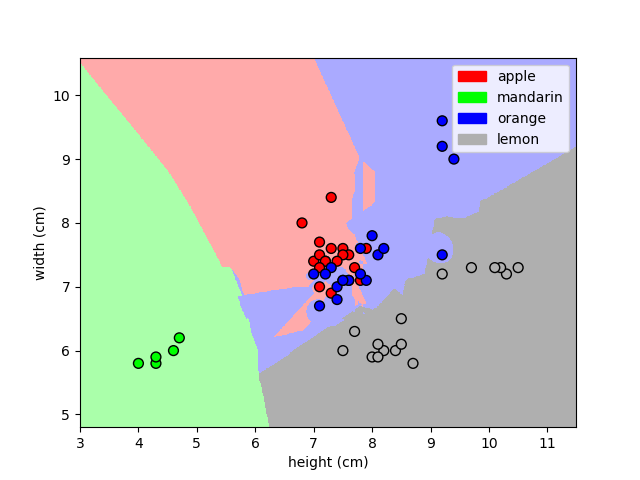

In [33]:
    X_mat = X[['height', 'width']].as_matrix()
    y_mat = y.as_matrix()

    # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF','#AFAFAF'])
    cmap_bold  = ListedColormap(['#FF0000', '#00FF00', '#0000FF','#AFAFAF'])

    clf = KNeighborsClassifier(n_neighbors = 3,weights='distance',n_jobs=-1)
    clf.fit(X_mat, y_mat)

    # Plot the decision boundary by assigning a color in the color map    
    # to each mesh point.
    
    mesh_step_size = .01  # step size in the mesh
    plot_symbol_size = 50
    
    x_min, x_max = X_mat[:, 0].min() - 1, X_mat[:, 0].max() + 1
    y_min, y_max = X_mat[:, 1].min() - 1, X_mat[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, mesh_step_size),
                         np.arange(y_min, y_max, mesh_step_size))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot training points
    plt.scatter(X_mat[:, 0], X_mat[:, 1], s=plot_symbol_size, c=y, cmap=cmap_bold, edgecolor = 'black')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    patch0 = mpatches.Patch(color='#FF0000', label='apple')
    patch1 = mpatches.Patch(color='#00FF00', label='mandarin')
    patch2 = mpatches.Patch(color='#0000FF', label='orange')
    patch3 = mpatches.Patch(color='#AFAFAF', label='lemon')
    plt.legend(handles=[patch0, patch1, patch2, patch3])

        
    plt.xlabel('height (cm)')
    plt.ylabel('width (cm)')
    
    plt.show()

### Sensibilidade aumento do conjunto de treinamento

<IPython.core.display.Javascript object>


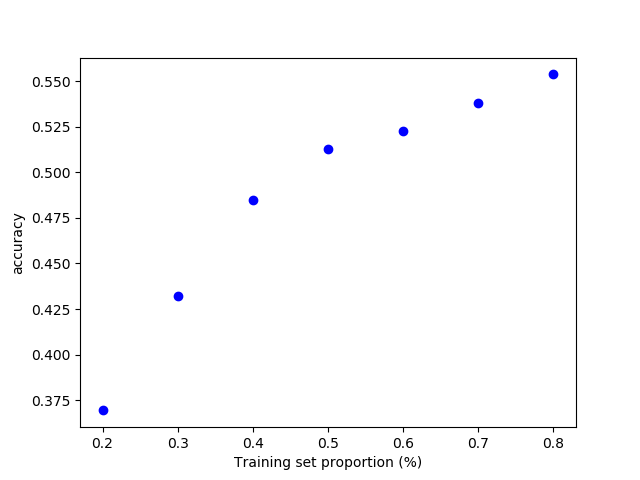

In [43]:
t = [0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]

knn = KNeighborsClassifier(n_neighbors = 5)

plt.figure()

for s in t:

    scores = []
    for i in range(1,1000):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-s)
        knn.fit(X_train, y_train)
        scores.append(knn.score(X_test, y_test))
    plt.plot(s, np.mean(scores), 'bo')

plt.xlabel('Training set proportion (%)')
plt.ylabel('accuracy');

### Cross-Validation

#### List odd neighbors to select as hyperparam through cross-validation

In [25]:
f = lambda x: np.where(x % 2 == 0)
k = pd.Series( f(np.linspace(1,30,30) )[0] )
k

0      1
1      3
2      5
3      7
4      9
5     11
6     13
7     15
8     17
9     19
10    21
11    23
12    25
13    27
14    29
dtype: int64

#### The search for each n_neighbor k is then computed via algorithm keyarg, auto to value based algorithm selection. The label of each neighbor to the test data can be weighted with the inverse of its distance to do the voting.  Number of k-folds passed by cv to do cross-validation.

In [31]:
score = np.zeros(np.size(k))
for kk,i in zip(k,k.index):
    knn = KNeighborsClassifier(n_neighbors=kk,weights='distance',n_jobs=-1)
    score[i] = np.mean(model_selection.cross_validate(knn, X, y, cv=5, scoring='accuracy')['test_score'])
score

array([0.64769231, 0.69641026, 0.67641026, 0.69641026, 0.66564103,
       0.66564103, 0.69897436, 0.68358974, 0.68358974, 0.68358974,
       0.68358974, 0.68358974, 0.66820513, 0.68487179, 0.68487179])

<IPython.core.display.Javascript object>


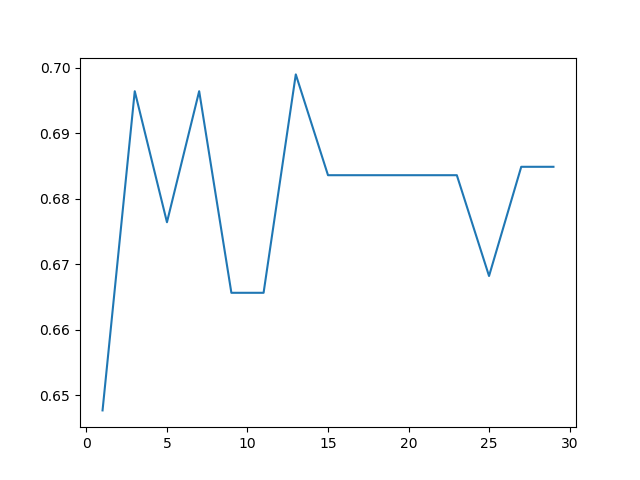

In [32]:
plt.plot(k,score)

## Support Vector Machines (SVM)

### Intro to SVM with Sklearn

In [3]:
from sklearn.svm import LinearSVC as LSVC
from sklearn.svm import LinearSVR as LSVR

fruits = pd.read_table('~/python/data/mix/fruit_data_with_colors.txt')
fruits.head()
y = fruits['fruit_label']
X = fruits[['mass','width','height']]
X.head()

,mass,width,height
0,192,8.4,7.3
1,180,8.0,6.8
2,176,7.4,7.2
3,86,6.2,4.7
4,84,6.0,4.6


#### Data Normalization 

<IPython.core.display.Javascript object>


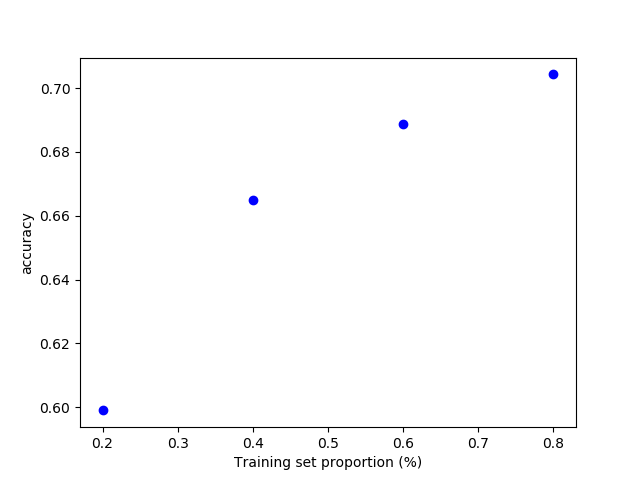

In [13]:
Xnorm = (X-X.mean())/np.std(X)
Xnorm.head()
t = [0.8,0.6,0.4,0.2]
lsvc = LSVC(C=0.3)
for s in t:

    scores = []    
    for i in range(1,1000):
        Xtrain, Xtest, ytrain, ytest = train_test_split(Xnorm, y, test_size = 1-s)
        lsvc.fit(Xtrain, ytrain)
        scores.append(lsvc.score(Xtest, ytest))
    plt.plot(s, np.mean(scores), 'bo')

plt.xlabel('Training set proportion (%)')
plt.ylabel('accuracy');

#### Cross-Validation

11.8

In [15]:
lsvc = LSVC(C=0.25)
score = np.mean(model_selection.cross_validate(lsvc,Xnorm,y,cv=5,scoring='accuracy')['test_score'])
score

0.6951282051282052

## Decision Trees 

In [62]:
from sklearn.tree import DecisionTreeClassifier


## Model Evaluation and Selection

##### Why not only accuracy for model evaluation, in Supervised Learning ? Motivation and definition of others evaluation metrics. Features -> Training -> Evaluation -> Recycling Tuning (Features and Models Hyperparams)

### Class imbalance, ineffective/bad/missing features, kernel/hyperparams wrong choosen
#### Choosen model can have similar accuracy to Null/dummy model in these cases. In case of imbalanced problem we will use another metrics

In [4]:
from sklearn.datasets import load_digits

dataset = load_digits()
X, y = dataset.data, dataset.target

for class_name, class_count in zip(dataset.target_names, np.bincount(dataset.target)):
    print(class_name,class_count)

(0, 178)
(1, 182)
(2, 177)
(3, 183)
(4, 181)
(5, 182)
(6, 181)
(7, 179)
(8, 174)
(9, 180)


#### Creating a dataset with imbalanced binary classes:   Negative class (0) is 'not digit 1'. Positive class (1) is 'digit 1'

In [5]:
y_binary_imbalanced = y.copy()
y_binary_imbalanced[y_binary_imbalanced != 1] = 0

print('Original labels:\t', y[1:30])
print('New binary labels:\t', y_binary_imbalanced[1:30])

('Original labels:\t', array([1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2,
       3, 4, 5, 6, 7, 8, 9]))
('New binary labels:\t', array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0]))


In [7]:
from sklearn.dummy import DummyClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y_binary_imbalanced, random_state=0)
# Negative class (0) is most frequent
dummy_majority = DummyClassifier(strategy = 'most_frequent').fit(X_train, y_train)
# Therefore the dummy 'most_frequent' classifier always predicts class 0
y_dummy_predictions = dummy_majority.predict(X_test)

y_dummy_predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

#### Negative class (0) is the most frequent class

In [8]:
np.bincount(y_binary_imbalanced)

array([1615,  182])

#### Accuracy of Support Vector Machine classifier

In [9]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', C=1).fit(X_train, y_train)
svm.score(X_test, y_test)

0.9088888888888889

In [10]:
dummy_majority.score(X_test, y_test)

0.9044444444444445

In [11]:
svm = SVC(kernel='linear', C=1).fit(X_train, y_train)
svm.score(X_test, y_test)

0.9777777777777777

### Confusion Matrix
#### A confusion matrix is a matrix 2 by 2 where the main diagonal has the true positives and true negatives of a binary classification problem, while the backward diagonal has the false positives and false negatives. Confusion matrix can help to derive new evaluation metrics to give different perspectives of the model depending on the modelling.

In [12]:
from sklearn.metrics import confusion_matrix

In [13]:
# produces random predictions w/ same class proportion as training set
dummy_classprop = DummyClassifier(strategy='stratified').fit(X_train, y_train)
y_classprop_predicted = dummy_classprop.predict(X_test)
confusion = confusion_matrix(y_test, y_classprop_predicted)

print('Random class-proportional prediction (dummy classifier)\n', confusion)

('Random class-proportional prediction (dummy classifier)\n', array([[371,  36],
       [ 36,   7]]))


In [23]:
svm = SVC(kernel='linear', C=1).fit(X_train, y_train)
svm_predicted = svm.predict(X_test)
confusion = confusion_matrix(y_test, svm_predicted)

print('Support vector machine classifier (linear kernel, C=1)\n', confusion)

('Support vector machine classifier (linear kernel, C=1)\n', array([[402,   5],
       [  5,  38]]))


### Evaluation Metrics for binary classification

- `Accuracy` = TP + TN / (TP + TN + FP + FN)
- `Precision` = TP / (TP + FP)
  - Rankeamento de Search Engine, Query Sugestion
  - Document Classification
  - Customer Task Classification
- `Recall` = TP / (TP + FN)  Also known as sensitivity, vies de identificacao da classe P em relacao a N.
  - Busca e extracao de informacao em documentos legais
  - Deteccao de tumor  
- `F1` = 2 * Precision * Recall / (Precision + Recall) 

- \begin{equation*} F_\beta = (1+\beta^2)\frac{Precision  Recall}{\beta^2 Precision + Recall}\end{equation*}. 
  - Se beta = 0.5  metrics eh precision oriented se beta = 2.0 metrics eh recall oriented.

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('Accuracy: {:.2f}'.format(accuracy_score(y_test, svm_predicted)))
print('Precision: {:.2f}'.format(precision_score(y_test, svm_predicted)))
print('Recall: {:.2f}'.format(recall_score(y_test, svm_predicted)))
print('F1: {:.2f}'.format(f1_score(y_test, svm_predicted)))

Accuracy: 0.98
Precision: 0.88
Recall: 0.88
F1: 0.88


#### Combined report with all above metrics

In [16]:
from sklearn.metrics import classification_report

print(classification_report(y_test, svm_predicted, target_names=['not 1', '1']))

             precision    recall  f1-score   support

      not 1       0.99      0.99      0.99       407
          1       0.88      0.88      0.88        43

avg / total       0.98      0.98      0.98       450



### Precision Recall Curve

In [24]:
svmscore = SVC(kernel='linear', C=1).fit(X_train, y_train).decision_function(X_test)
print(svmscore)

[-2.15865251e+01 -1.15407500e+01 -1.32301040e+01 -2.17817157e+01
 -2.29313916e+01 -1.25739456e+01  4.60677857e+00 -1.98231308e+01
 -2.24396293e+01 -2.56435969e+01 -1.75762131e+01 -1.29585107e+01
 -2.42740043e+01 -8.70254346e+00 -6.63090763e+00 -6.37860706e+00
  9.18827358e+00 -2.31055863e+01 -1.57031649e+01 -1.65345471e+01
 -1.91732607e+01 -1.74274481e+01 -1.77658649e+01 -9.00897881e+00
 -2.62584222e+01 -1.72487038e+01 -1.72602894e+01 -2.93617276e+01
 -2.11166952e+01 -2.09205751e+01 -1.61106109e+01 -2.82789699e+01
 -1.34334939e+01 -1.18151992e+01 -1.29418059e+01 -1.68135179e+01
 -1.95020295e+01 -2.97949735e+00 -1.93597787e+01  1.34750479e+01
 -3.79507416e+00 -1.54492781e+01 -1.96066900e+01 -2.79760137e+01
 -5.98150926e-01 -2.89673375e+01 -2.52538250e+01 -1.67063767e+01
 -2.11175643e+01  6.56436418e+00 -2.20712698e+01 -9.36199940e+00
 -2.29393608e+01 -1.92292985e+01 -3.26935981e+01 -2.75513248e+01
 -1.05309128e+01  7.99602476e-01 -2.44814520e+01 -2.65414314e+01
 -1.62885629e+01 -3.19179

<IPython.core.display.Javascript object>


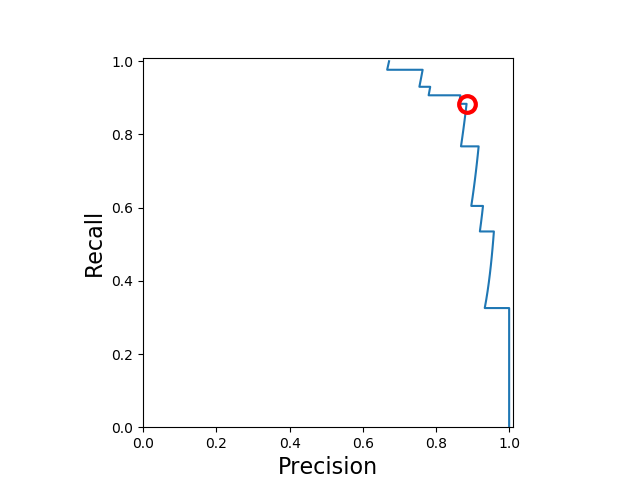

/home/humannoise/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [25]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, svmscore)
closest_zero = np.argmin(np.abs(thresholds))
closest_zero_p = precision[closest_zero]
closest_zero_r = recall[closest_zero]

plt.figure()
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.plot(precision, recall, label='Precision-Recall Curve')
plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3)
plt.xlabel('Precision', fontsize=16)
plt.ylabel('Recall', fontsize=16)
plt.axes().set_aspect('equal')
plt.show()

<IPython.core.display.Javascript object>


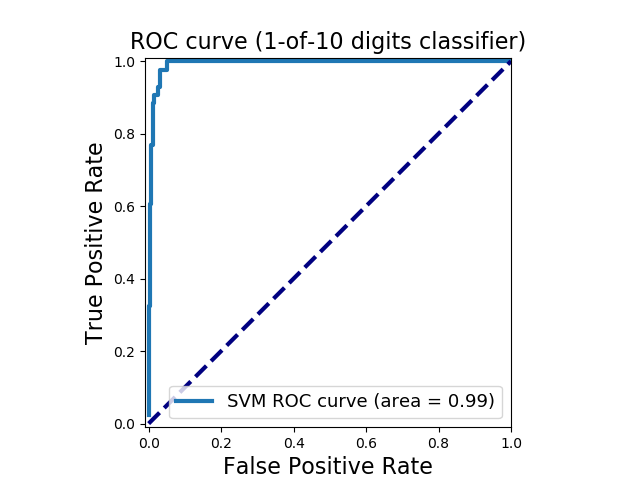

/home/humannoise/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [26]:
from sklearn.metrics import roc_curve, auc

X_train, X_test, y_train, y_test = train_test_split(X, y_binary_imbalanced, random_state=0)

svmscore = SVC(kernel='linear', C=1).fit(X_train, y_train).decision_function(X_test)

fpr, tpr, _ = roc_curve(y_test, svmscore)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, lw=3, label='SVM ROC curve (area = {:0.2f})'.format(roc_auc))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (1-of-10 digits classifier)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

<IPython.core.display.Javascript object>


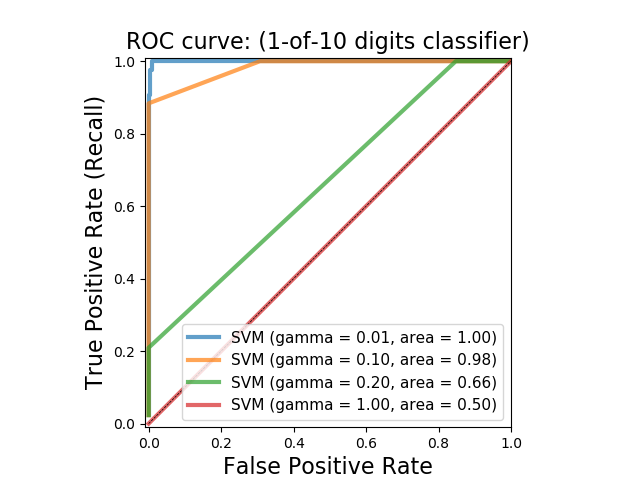

gamma = 0.01  accuracy = 0.91   AUC = 1.00
gamma = 0.10  accuracy = 0.90   AUC = 0.98
gamma = 0.20  accuracy = 0.90   AUC = 0.66
gamma = 1.00  accuracy = 0.90   AUC = 0.50


/home/humannoise/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [28]:
from matplotlib import cm

X_train, X_test, y_train, y_test = train_test_split(X, y_binary_imbalanced, random_state=0)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
for g in [0.01, 0.1, 0.20, 1]:
    svm = SVC(gamma=g).fit(X_train, y_train)
    svmscore = svm.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, svmscore)
    roc_auc = auc(fpr, tpr)
    accuracy = svm.score(X_test, y_test)
    print("gamma = {:.2f}  accuracy = {:.2f}   AUC = {:.2f}".format(g, accuracy, 
                                                                    roc_auc))
    plt.plot(fpr, tpr, lw=3, alpha=0.7, 
             label='SVM (gamma = {:0.2f}, area = {:0.2f})'.format(g, roc_auc))

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate (Recall)', fontsize=16)
plt.plot([0, 1], [0, 1], color='k', lw=0.5, linestyle='--')
plt.legend(loc="lower right", fontsize=11)
plt.title('ROC curve: (1-of-10 digits classifier)', fontsize=16)
plt.axes().set_aspect('equal')

plt.show()

### Model selection using evaluation metrics

In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

dataset = load_digits()
# again, making this a binary problem with 'digit 1' as positive class 
# and 'not 1' as negative class
X, y = dataset.data, dataset.target == 1
clf = SVC(kernel='linear', C=1)

# accuracy is the default scoring metric
print('Cross-validation (accuracy)', cross_val_score(clf, X, y, cv=5))
# use AUC as scoring metric
print('Cross-validation (AUC)', cross_val_score(clf, X, y, cv=5, scoring = 'roc_auc'))
# use recall as scoring metric
print('Cross-validation (recall)', cross_val_score(clf, X, y, cv=5, scoring = 'recall'))

('Cross-validation (accuracy)', array([0.91944444, 0.98611111, 0.97214485, 0.97493036, 0.96935933]))
('Cross-validation (AUC)', array([0.9641871 , 0.9976571 , 0.99372205, 0.99699002, 0.98675611]))
('Cross-validation (recall)', array([0.81081081, 0.89189189, 0.83333333, 0.83333333, 0.83333333]))


In [30]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

dataset = load_digits()
X, y = dataset.data, dataset.target == 1
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

clf = SVC(kernel='rbf')
grid_values = {'gamma': [0.001, 0.01, 0.05, 0.1, 1, 10, 100]}

# default metric to optimize over grid parameters: accuracy
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values)
grid_clf_acc.fit(X_train, y_train)
y_decision_fn_scores_acc = grid_clf_acc.decision_function(X_test) 

print('Grid best parameter (max. accuracy): ', grid_clf_acc.best_params_)
print('Grid best score (accuracy): ', grid_clf_acc.best_score_)

# alternative metric to optimize over grid parameters: AUC
grid_clf_auc = GridSearchCV(clf, param_grid = grid_values, scoring = 'roc_auc')
grid_clf_auc.fit(X_train, y_train)
y_decision_fn_scores_auc = grid_clf_auc.decision_function(X_test) 

print('Test set AUC: ', roc_auc_score(y_test, y_decision_fn_scores_auc))
print('Grid best parameter (max. AUC): ', grid_clf_auc.best_params_)
print('Grid best score (AUC): ', grid_clf_auc.best_score_)


('Grid best parameter (max. accuracy): ', {'gamma': 0.001})
('Grid best score (accuracy): ', 0.9962880475129918)
('Test set AUC: ', 0.99982858122393)
('Grid best parameter (max. AUC): ', {'gamma': 0.001})
('Grid best score (AUC): ', 0.9998741278302142)


In [31]:
from sklearn.metrics.scorer import SCORERS

print(sorted(list(SCORERS.keys())))

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'log_loss', 'mean_absolute_error', 'mean_squared_error', 'median_absolute_error', 'mutual_info_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'v_measure_score']


## Naive Bayes